### Updated MFCCs

In [67]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

# Parameters
sr = 44100
window_size = int(0.032 * sr)  # 32 ms window
hop_length = int(0.008 * sr)   # 8 ms hop length
n_mfcc = 13  # Number of MFCCs to extract
instruments = ['vocals', 'bass', 'drums', 'other']  # Instrument names as per musdb stems

def load_and_compute_mfcc(file_path, sr, n_mfcc, hop_length, window_size):
    """
    Load an audio file and compute its MFCCs.
    """
    audio, _ = librosa.load(file_path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc,
        hop_length=hop_length, n_fft=window_size
    )
    return mfcc

mfcc_data_train = {instrument: [] for instrument in instruments}
mfcc_data_test = {instrument: [] for instrument in instruments}

# Paths to data directories
train_data_dir = '../data/10_songs_train_20s'
test_data_dir = '../data/10_songs_test_20s'

def process_dataset(data_dir, mfcc_data):
    song_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir)
                 if os.path.isdir(os.path.join(data_dir, d))]
    song_dirs.sort()  # Ensure consistent order

    for song_dir in song_dirs:
        for instrument in instruments:
            # Construct the file path
            file_name = f'{instrument}.wav'  # Adjust the file extension if needed
            file_path = os.path.join(song_dir, file_name)
            
            # Check if file exists
            if not os.path.exists(file_path):
                print(f'File not found: {file_path}')
                continue
            
            # Load and compute MFCCs
            mfcc = load_and_compute_mfcc(
                file_path, sr, n_mfcc,
                hop_length, window_size
            )
            
            # Append to the list for this instrument
            mfcc_data[instrument].append(mfcc)

process_dataset(train_data_dir, mfcc_data_train)
process_dataset(test_data_dir, mfcc_data_test)

def compute_mean_mfccs_per_song(mfcc_data):
    """
    Compute the mean MFCC coefficients over time for each song.
    Returns a dictionary with instruments as keys and a list of mean MFCC arrays.
    """
    mean_mfccs = {instrument: [] for instrument in instruments}
    for instrument in instruments:
        for mfcc in mfcc_data[instrument]:
            # Compute mean over time (axis=1)
            mean_mfcc = np.mean(mfcc, axis=1)
            mean_mfccs[instrument].append(mean_mfcc)
    return mean_mfccs

mean_mfccs_train = compute_mean_mfccs_per_song(mfcc_data_train)
mean_mfccs_test = compute_mean_mfccs_per_song(mfcc_data_test)

def compute_mean_std(mean_mfccs):
    """
    Compute the mean and standard deviation of MFCC coefficients across songs.
    Returns dictionaries with instruments as keys and arrays of mean and std values.
    """
    mean_values = {}
    std_values = {}
    for instrument in instruments:
        # Stack the mean MFCCs for this instrument into a 2D array (songs x coefficients)
        data = np.stack(mean_mfccs[instrument], axis=0)
        # Compute mean and std over songs (axis=0)
        mean_values[instrument] = np.mean(data, axis=0)
        std_values[instrument] = np.std(data, axis=0)
    return mean_values, std_values

mean_values_train, std_values_train = compute_mean_std(mean_mfccs_train)
mean_values_test, std_values_test = compute_mean_std(mean_mfccs_test)

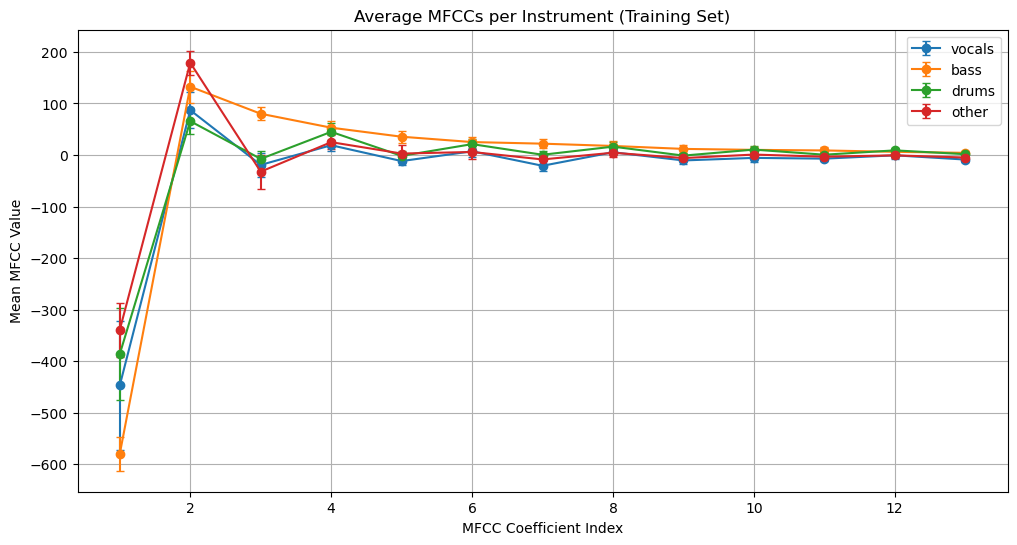

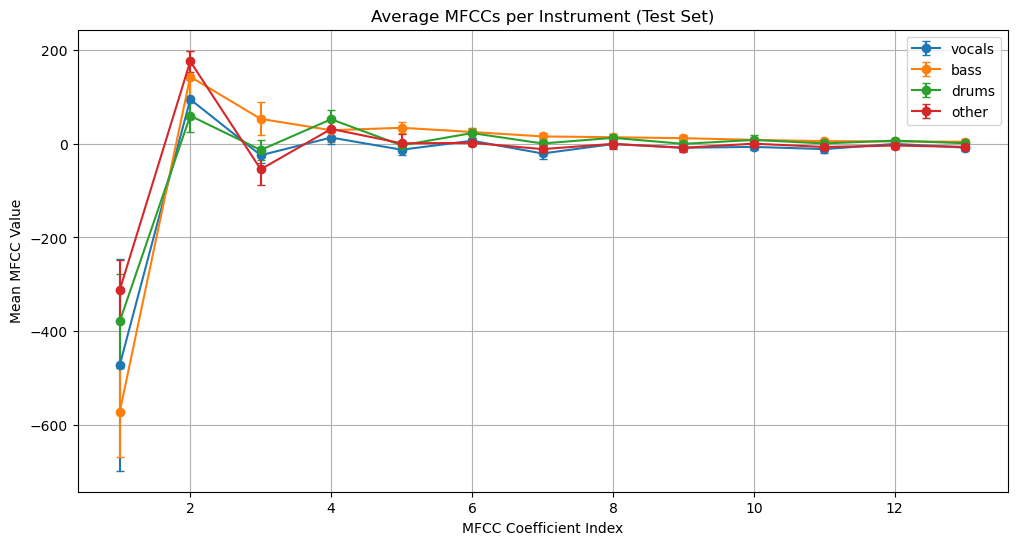

In [8]:
def plot_mean_mfccs(mean_values, std_values, title):
    """
    Plot mean MFCC coefficients with error bars for each instrument.
    """
    coefficients = np.arange(1, n_mfcc + 1)
    plt.figure(figsize=(12, 6))
    
    for instrument in instruments:
        mean = mean_values[instrument]
        std = std_values[instrument]
        plt.errorbar(coefficients, mean, yerr=std, label=instrument, capsize=3, marker='o')
    
    plt.xlabel('MFCC Coefficient Index')
    plt.ylabel('Mean MFCC Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_mean_mfccs(mean_values_train, std_values_train, 'Average MFCCs per Instrument (Training Set)')
plot_mean_mfccs(mean_values_test, std_values_test, 'Average MFCCs per Instrument (Test Set)')

### Final

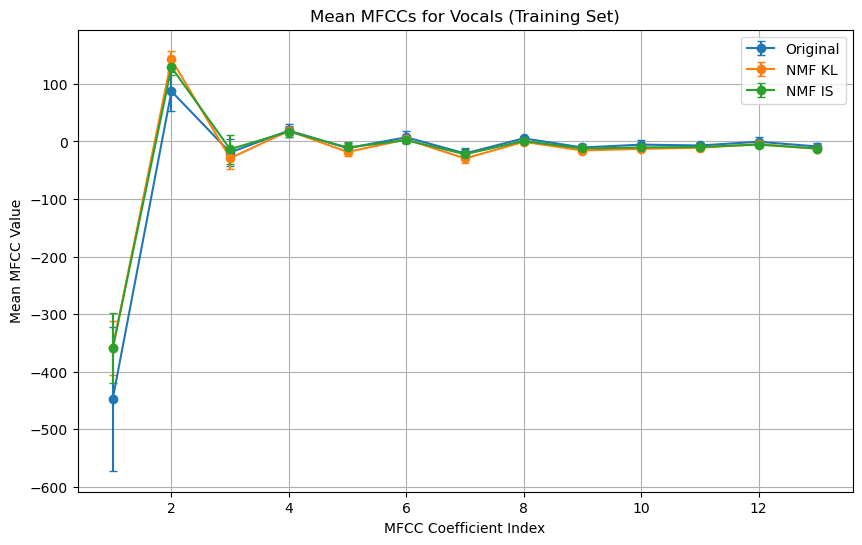

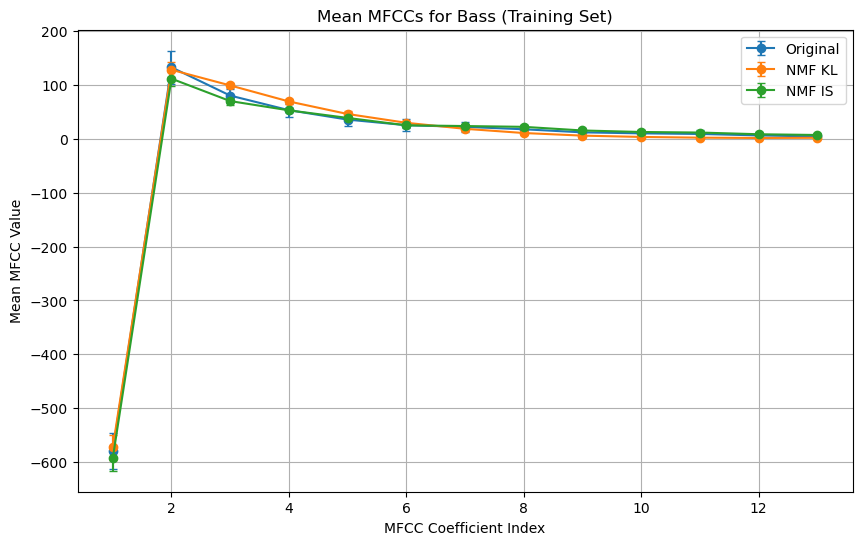

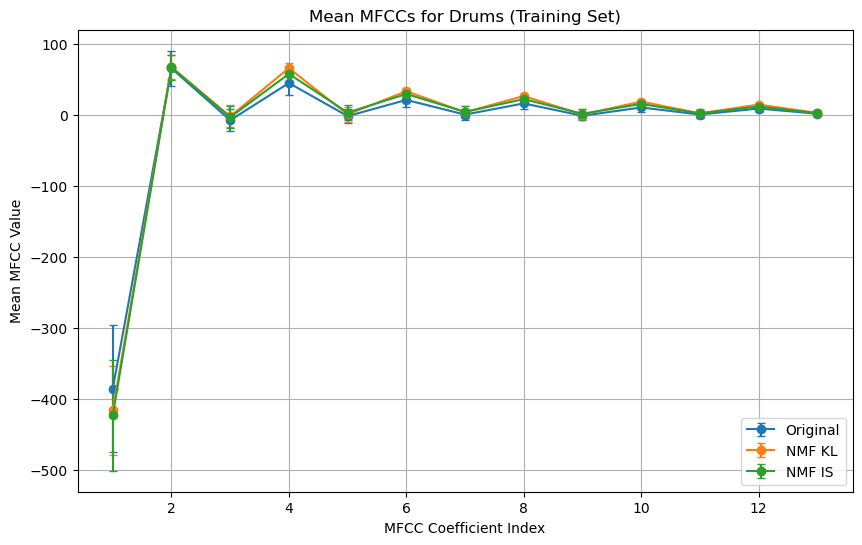

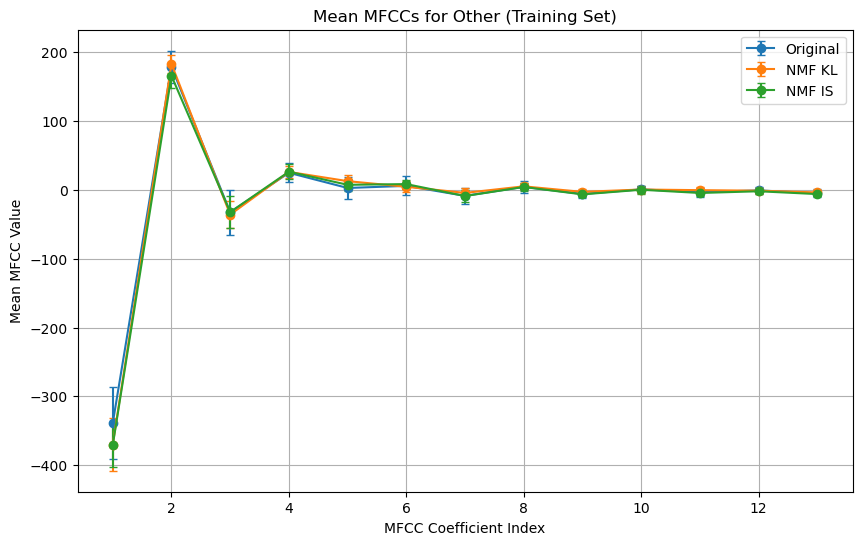

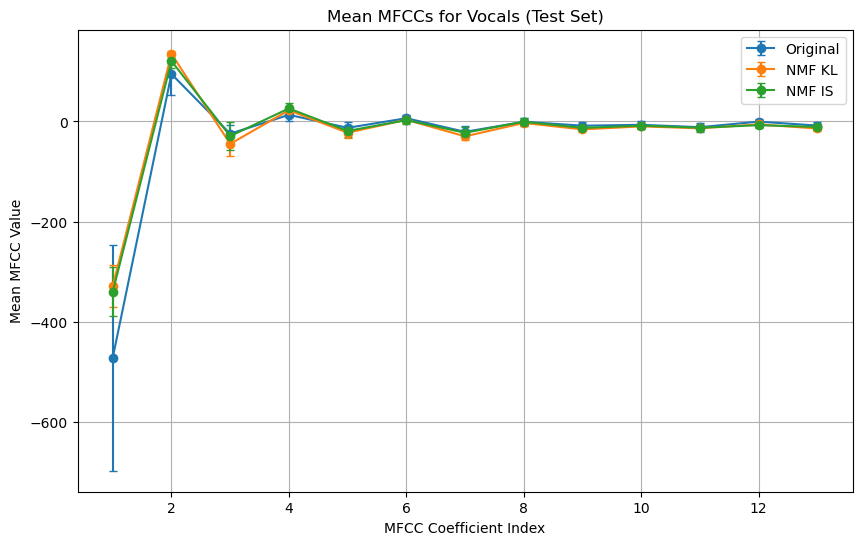

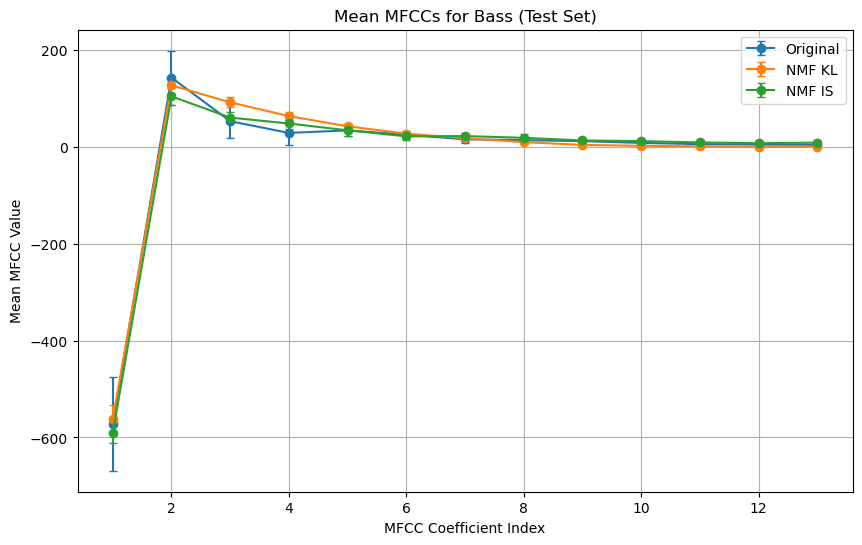

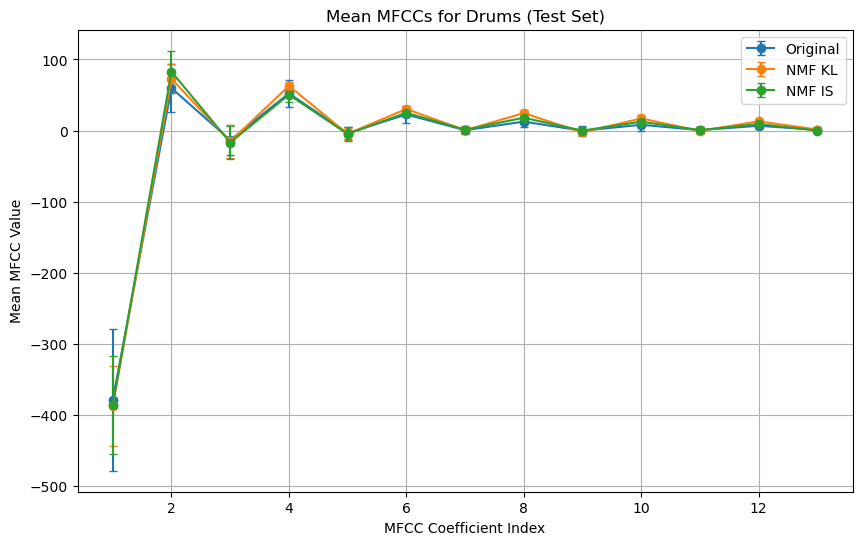

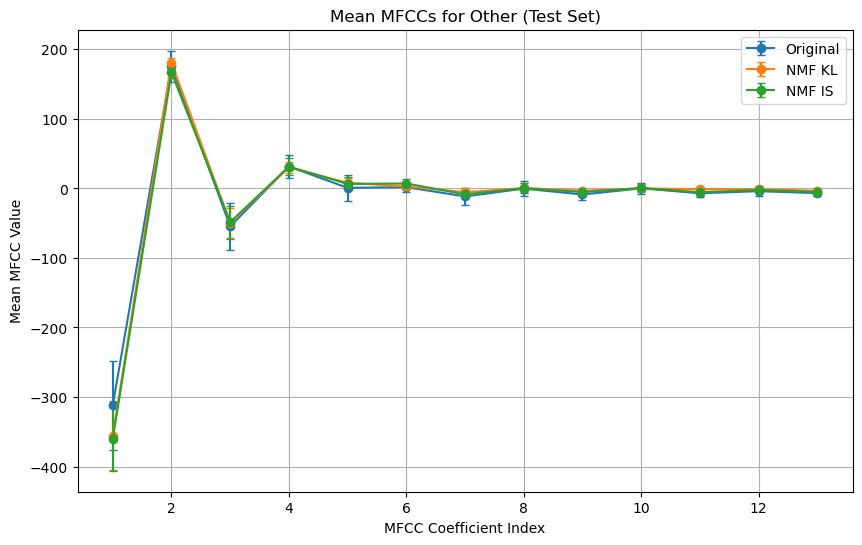

In [16]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# Parameters
sr = 44100
window_size = int(0.032 * sr)  # 32 ms window
hop_length = int(0.008 * sr)   # 8 ms hop length
n_mfcc = 13  # Number of MFCCs to extract
coefficients = np.arange(1, n_mfcc + 1)
instruments = ['vocals', 'bass', 'drums', 'other']

# Data paths
train_data_dir = '../data/10_songs_train_20s'
test_data_dir = '../data/10_songs_test_20s'

nmf_methods = ['IS', 'KL']
nmf_data_dirs = {
    'IS_train': '../data/IS/train',
    'IS_test': '../data/IS/test',
    'KL_train': '../data/KL/train',
    'KL_test': '../data/KL/test',
}

def load_and_compute_mfcc(file_path):
    """
    Load an audio file and compute its MFCCs.
    """
    audio, _ = librosa.load(file_path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc,
        hop_length=hop_length, n_fft=window_size
    )
    return mfcc

def process_original_stems(data_dir):
    """
    Process original stems in the specified directory.
    Returns a dictionary with instruments as keys and lists of MFCC arrays.
    """
    mfcc_data = {instrument: [] for instrument in instruments}
    
    song_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir)
                 if os.path.isdir(os.path.join(data_dir, d))]
    song_dirs.sort()  # Ensure consistent order
    
    for song_dir in song_dirs:
        for instrument in instruments:
            file_name = f'{instrument}.wav'
            file_path = os.path.join(song_dir, file_name)
            if not os.path.exists(file_path):
                print(f'File not found: {file_path}')
                continue
            # Compute MFCCs
            mfcc = load_and_compute_mfcc(file_path)
            mfcc_data[instrument].append(mfcc)
    return mfcc_data

def process_nmf_reconstructed_data(nmf_method, dataset_type):
    """
    Process NMF reconstructed data for all instruments.
    nmf_method: 'IS' or 'KL'
    dataset_type: 'train' or 'test'
    Returns a dictionary with instruments as keys and lists of MFCC arrays.
    """
    nmf_data_dir = nmf_data_dirs[f'{nmf_method}_{dataset_type}']
    mfcc_data = {instrument: [] for instrument in instruments}
    
    files = os.listdir(nmf_data_dir)
    files.sort()
    for file in files:
        file_path = os.path.join(nmf_data_dir, file)
        if not os.path.isfile(file_path):
            continue
    
        # Parse file names according to conventions
        if dataset_type == 'test':
            # e.g., '1_vocals_is.wav'
            parts = file.split('_')
            if len(parts) != 3:
                continue
            song_num, instrument, method_ext = parts
            method = method_ext.split('.')[0]
            if method != f'{nmf_method.lower()}':
                continue
            if instrument not in instruments:
                continue
        elif dataset_type == 'train':
            # e.g., 'train_1_vocals_is.wav'
            parts = file.split('_')
            if len(parts) != 4:
                continue
            _, song_num, instrument, method_ext = parts
            method = method_ext.split('.')[0]
            if method != f'{nmf_method.lower()}':
                continue
            if instrument not in instruments:
                continue
        else:
            continue  # Invalid dataset_type
    
        # Compute MFCCs
        mfcc = load_and_compute_mfcc(file_path)
        mfcc_data[instrument].append(mfcc)
    return mfcc_data

# Training Set
mfcc_data_train = process_original_stems(train_data_dir)

# Test Set
mfcc_data_test = process_original_stems(test_data_dir)

# NMF IS Method - Training Set
mfcc_data_nmf_is_train = process_nmf_reconstructed_data('IS', 'train')

# NMF KL Method - Training Set
mfcc_data_nmf_kl_train = process_nmf_reconstructed_data('KL', 'train')

# NMF IS Method - Test Set
mfcc_data_nmf_is_test = process_nmf_reconstructed_data('IS', 'test')

# NMF KL Method - Test Set
mfcc_data_nmf_kl_test = process_nmf_reconstructed_data('KL', 'test')

def compute_mean_mfccs(mfcc_list):
    """
    Compute mean MFCC over time for each MFCC array in the list.
    """
    mean_mfccs = []
    for mfcc in mfcc_list:
        mean_mfcc = np.mean(mfcc, axis=1)  # Mean over time frames
        mean_mfccs.append(mean_mfcc)
    return mean_mfccs

def compute_mean_std_mfccs(mfcc_data):
    """
    Compute mean and standard deviation of MFCC coefficients across songs for each instrument.
    """
    mean_values = {}
    std_values = {}
    for instrument in instruments:
        mfcc_list = mfcc_data[instrument]
        if not mfcc_list:
            continue
        mean_mfccs = compute_mean_mfccs(mfcc_list)
        data = np.stack(mean_mfccs, axis=0)  # Shape: (num_songs, n_mfcc)
        mean_values[instrument] = np.mean(data, axis=0)
        std_values[instrument] = np.std(data, axis=0)
    return mean_values, std_values

# Original
mean_values_train_original, std_values_train_original = compute_mean_std_mfccs(mfcc_data_train)

# NMF IS
mean_values_train_nmf_is, std_values_train_nmf_is = compute_mean_std_mfccs(mfcc_data_nmf_is_train)

# NMF KL
mean_values_train_nmf_kl, std_values_train_nmf_kl = compute_mean_std_mfccs(mfcc_data_nmf_kl_train)

# Original
mean_values_test_original, std_values_test_original = compute_mean_std_mfccs(mfcc_data_test)

# NMF IS
mean_values_test_nmf_is, std_values_test_nmf_is = compute_mean_std_mfccs(mfcc_data_nmf_is_test)

# NMF KL
mean_values_test_nmf_kl, std_values_test_nmf_kl = compute_mean_std_mfccs(mfcc_data_nmf_kl_test)

def plot_mean_mfccs_with_errorbars(mean_values_list, std_values_list, labels, instrument, title):
    """
    Plot mean MFCC coefficients with error bars for given data.
    mean_values_list: List of mean_values dictionaries.
    std_values_list: List of std_values dictionaries.
    labels: Labels for each dataset (e.g., ['Original', 'NMF KL', 'NMF IS'])
    instrument: The instrument to plot.
    title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    for mean_values, std_values, label in zip(mean_values_list, std_values_list, labels):
        if instrument not in mean_values:
            continue
        mean = mean_values[instrument]
        std = std_values[instrument]
        plt.errorbar(coefficients, mean, yerr=std, label=label, capsize=3, marker='o')
    
    plt.xlabel('MFCC Coefficient Index')
    plt.ylabel('Mean MFCC Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

datasets = ['Original', 'NMF KL', 'NMF IS']
mean_values_list_train = [mean_values_train_original, mean_values_train_nmf_kl, mean_values_train_nmf_is]
std_values_list_train = [std_values_train_original, std_values_train_nmf_kl, std_values_train_nmf_is]

for instrument in instruments:
    title = f'Mean MFCCs for {instrument.capitalize()} (Training Set)'
    plot_mean_mfccs_with_errorbars(mean_values_list_train, std_values_list_train, datasets, instrument, title)

mean_values_list_test = [mean_values_test_original, mean_values_test_nmf_kl, mean_values_test_nmf_is]
std_values_list_test = [std_values_test_original, std_values_test_nmf_kl, std_values_test_nmf_is]

for instrument in instruments:
    title = f'Mean MFCCs for {instrument.capitalize()} (Test Set)'
    plot_mean_mfccs_with_errorbars(mean_values_list_test, std_values_list_test, datasets, instrument, title)

### Cosine similarities

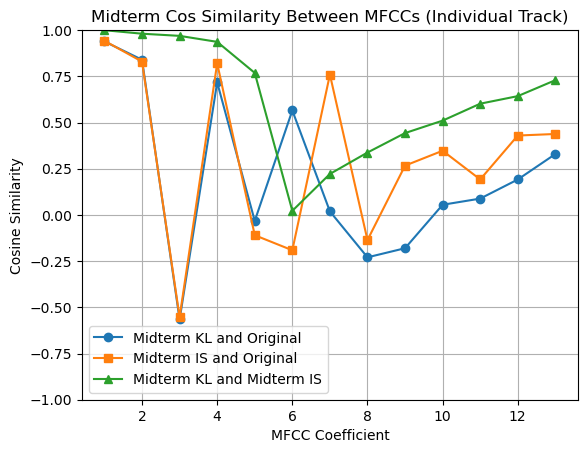

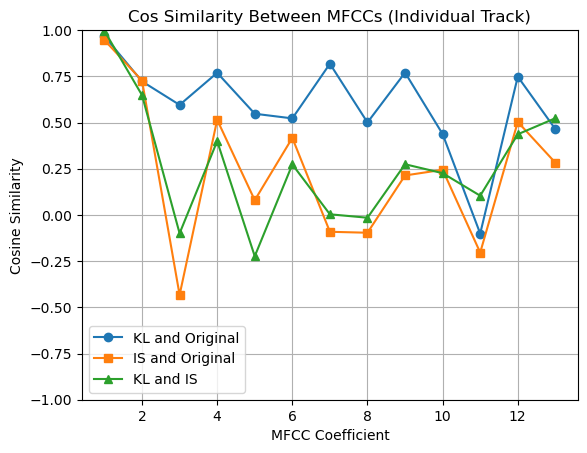

In [58]:
def cosine_similarity_matrices(matrix1, matrix2):
    """
    Calculate the cosine similarity between corresponding rows of two matrices.

    Parameters:
        matrix1 (numpy.ndarray): First matrix (n x m).
        matrix2 (numpy.ndarray): Second matrix (n x m), must have the same shape as matrix1.

    Returns:
        numpy.ndarray: A 1D array of cosine similarities for each row in the matrices.
    """
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape.")

    # Calculate the dot product of corresponding rows
    dot_product = np.sum(matrix1 * matrix2, axis=1)

    # Calculate the L2 norms (magnitudes) of the rows in each matrix
    norm1 = np.linalg.norm(matrix1, axis=1)
    norm2 = np.linalg.norm(matrix2, axis=1)

    # Calculate cosine similarity for each row
    cosine_similarities = dot_product / (norm1 * norm2)

    # Replace NaN values with 0 (in case of zero vectors)
    cosine_similarities = np.nan_to_num(cosine_similarities)

    return cosine_similarities

# Paths to individual track files
midterm_original_track_path = 'vocal_track_short_1.mp3'
midterm_kl_track_path = 'vocals_21s_rec.mp3'
midterm_is_track_path = 'vocals_21s_rec_is.mp3'

# Load MFCC matrices
midterm_mfcc_original = load_and_compute_mfcc(midterm_original_track_path)
midterm_mfcc_kl = load_and_compute_mfcc(midterm_kl_track_path)
midterm_mfcc_is = load_and_compute_mfcc(midterm_is_track_path)

# Ensure the shapes match
min_frames = min(midterm_mfcc_original.shape[1], midterm_mfcc_kl.shape[1], midterm_mfcc_is.shape[1])

# Truncate MFCC matrices to the minimum number of frames
mfcc_original = midterm_mfcc_original[:, :min_frames]
mfcc_kl = midterm_mfcc_kl[:, :min_frames]
mfcc_is = midterm_mfcc_is[:, :min_frames]

# Compute cosine similarities between the MFCC matrices
midterm_kl_and_orig = cosine_similarity_matrices(mfcc_kl, mfcc_original)
midterm_is_and_orig = cosine_similarity_matrices(mfcc_is, mfcc_original)
midterm_kl_and_is = cosine_similarity_matrices(mfcc_kl, mfcc_is)

# plt.figure(figsize=(10, 6))
plt.plot(coefficients, midterm_kl_and_orig, marker='o', label="Midterm KL and Original")
plt.plot(coefficients, midterm_is_and_orig, marker='s', label="Midterm IS and Original")
plt.plot(coefficients, midterm_kl_and_is, marker='^', label="Midterm KL and Midterm IS")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Cosine Similarity")
plt.title("Midterm Cos Similarity Between MFCCs (Individual Track)")
plt.legend()
plt.grid(True)
plt.ylim(-1, 1)
plt.show()

# Paths to individual track files
original_track_path = 'vocal_track_short_1.mp3'
kl_track_path = './track_kl/vocals.mp3'
is_track_path = './track_is/vocals.mp3'

# Load MFCC matrices
mfcc_original = load_and_compute_mfcc(original_track_path)
mfcc_kl = load_and_compute_mfcc(kl_track_path)
mfcc_is = load_and_compute_mfcc(is_track_path)

# Ensure the shapes match
min_frames = min(mfcc_original.shape[1], mfcc_kl.shape[1], mfcc_is.shape[1])

# Truncate MFCC matrices to the minimum number of frames
mfcc_original = mfcc_original[:, :min_frames]
mfcc_kl = mfcc_kl[:, :min_frames]
mfcc_is = mfcc_is[:, :min_frames]

# Compute cosine similarities between the MFCC matrices
kl_and_orig = cosine_similarity_matrices(mfcc_kl, mfcc_original)
is_and_orig = cosine_similarity_matrices(mfcc_is, mfcc_original)
kl_and_is = cosine_similarity_matrices(mfcc_kl, mfcc_is)

# plt.figure(figsize=(10, 6))
plt.plot(coefficients, kl_and_orig, marker='o', label="KL and Original")
plt.plot(coefficients, is_and_orig, marker='s', label="IS and Original")
plt.plot(coefficients, kl_and_is, marker='^', label="KL and IS")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Cosine Similarity")
plt.title("Cos Similarity Between MFCCs (Individual Track)")
plt.legend()
plt.grid(True)
plt.ylim(-1, 1)
plt.show()

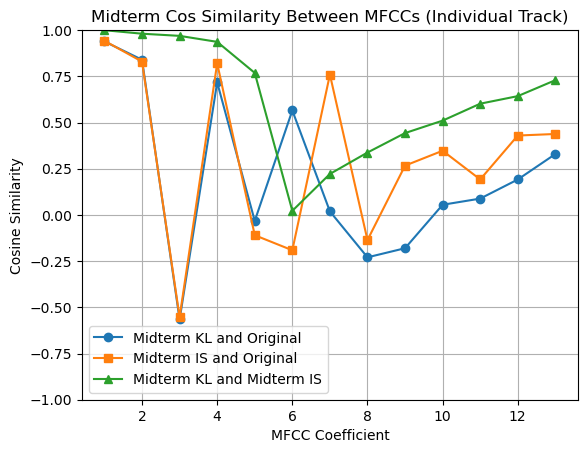

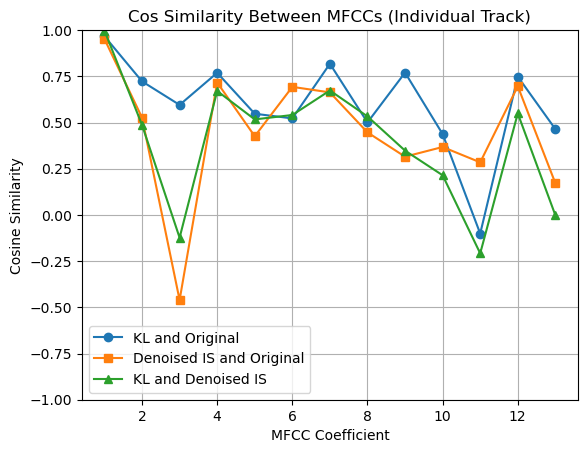

In [59]:
def cosine_similarity_matrices(matrix1, matrix2):
    """
    Calculate the cosine similarity between corresponding rows of two matrices.

    Parameters:
        matrix1 (numpy.ndarray): First matrix (n x m).
        matrix2 (numpy.ndarray): Second matrix (n x m), must have the same shape as matrix1.

    Returns:
        numpy.ndarray: A 1D array of cosine similarities for each row in the matrices.
    """
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape.")

    # Calculate the dot product of corresponding rows
    dot_product = np.sum(matrix1 * matrix2, axis=1)

    # Calculate the L2 norms (magnitudes) of the rows in each matrix
    norm1 = np.linalg.norm(matrix1, axis=1)
    norm2 = np.linalg.norm(matrix2, axis=1)

    # Calculate cosine similarity for each row
    cosine_similarities = dot_product / (norm1 * norm2)

    # Replace NaN values with 0 (in case of zero vectors)
    cosine_similarities = np.nan_to_num(cosine_similarities)

    return cosine_similarities

# Paths to individual track files
midterm_original_track_path = 'vocal_track_short_1.mp3'
midterm_kl_track_path = 'vocals_21s_rec.mp3'
midterm_is_track_path = 'vocals_21s_rec_is.mp3'

# Load MFCC matrices
midterm_mfcc_original = load_and_compute_mfcc(midterm_original_track_path)
midterm_mfcc_kl = load_and_compute_mfcc(midterm_kl_track_path)
midterm_mfcc_is = load_and_compute_mfcc(midterm_is_track_path)

# Ensure the shapes match
min_frames = min(midterm_mfcc_original.shape[1], midterm_mfcc_kl.shape[1], midterm_mfcc_is.shape[1])

# Truncate MFCC matrices to the minimum number of frames
mfcc_original = midterm_mfcc_original[:, :min_frames]
mfcc_kl = midterm_mfcc_kl[:, :min_frames]
mfcc_is = midterm_mfcc_is[:, :min_frames]

# Compute cosine similarities between the MFCC matrices
midterm_kl_and_orig = cosine_similarity_matrices(mfcc_kl, mfcc_original)
midterm_is_and_orig = cosine_similarity_matrices(mfcc_is, mfcc_original)
midterm_kl_and_is = cosine_similarity_matrices(mfcc_kl, mfcc_is)

# plt.figure(figsize=(10, 6))
plt.plot(coefficients, midterm_kl_and_orig, marker='o', label="Midterm KL and Original")
plt.plot(coefficients, midterm_is_and_orig, marker='s', label="Midterm IS and Original")
plt.plot(coefficients, midterm_kl_and_is, marker='^', label="Midterm KL and Midterm IS")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Cosine Similarity")
plt.title("Midterm Cos Similarity Between MFCCs (Individual Track)")
plt.legend()
plt.grid(True)
plt.ylim(-1, 1)
plt.show()

# Paths to individual track files
original_track_path = 'vocal_track_short_1.mp3'
kl_track_path = './track_kl/vocals.mp3'
is_track_path = './track_is/vocals_denoised.mp3'

# Load MFCC matrices
mfcc_original = load_and_compute_mfcc(original_track_path)
mfcc_kl = load_and_compute_mfcc(kl_track_path)
mfcc_is = load_and_compute_mfcc(is_track_path)

# Ensure the shapes match
min_frames = min(mfcc_original.shape[1], mfcc_kl.shape[1], mfcc_is.shape[1])

# Truncate MFCC matrices to the minimum number of frames
mfcc_original = mfcc_original[:, :min_frames]
mfcc_kl = mfcc_kl[:, :min_frames]
mfcc_is = mfcc_is[:, :min_frames]

# Compute cosine similarities between the MFCC matrices
kl_and_orig = cosine_similarity_matrices(mfcc_kl, mfcc_original)
is_and_orig = cosine_similarity_matrices(mfcc_is, mfcc_original)
kl_and_is = cosine_similarity_matrices(mfcc_kl, mfcc_is)

# plt.figure(figsize=(10, 6))
plt.plot(coefficients, kl_and_orig, marker='o', label="KL and Original")
plt.plot(coefficients, is_and_orig, marker='s', label="Denoised IS and Original")
plt.plot(coefficients, kl_and_is, marker='^', label="KL and Denoised IS")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Cosine Similarity")
plt.title("Cos Similarity Between MFCCs (Individual Track)")
plt.legend()
plt.grid(True)
plt.ylim(-1, 1)
plt.show()

C:\Users\tianyun\AppData\Local\Temp\ipykernel_29128\677735441.py:24: RuntimeWarning: invalid value encountered in divide
  cosine_similarities = dot_product / (norm1 * norm2)


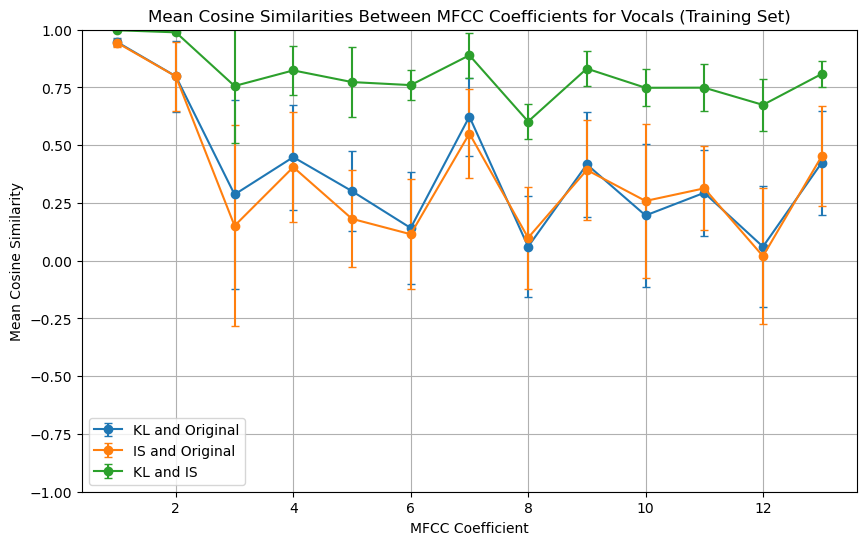

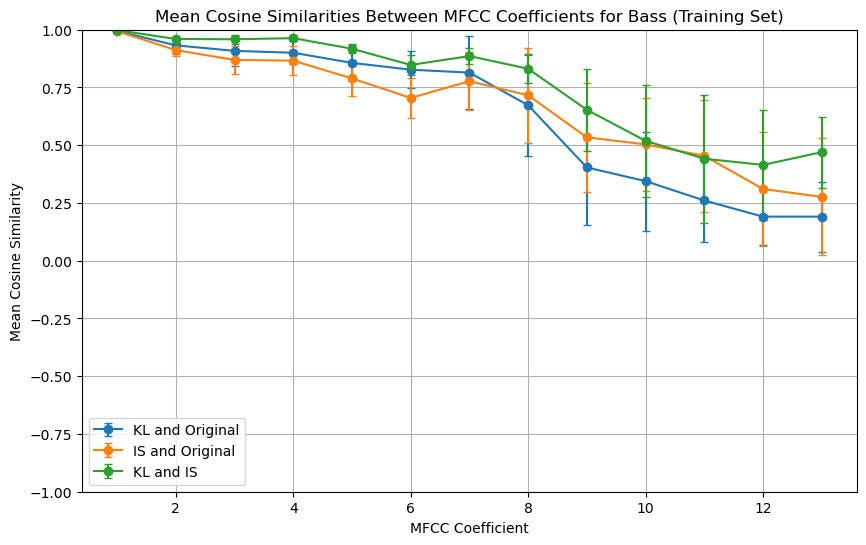

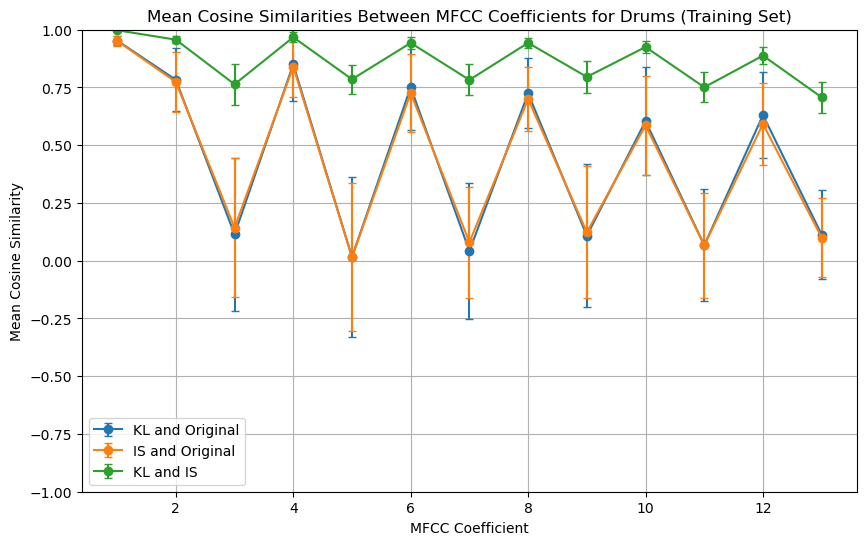

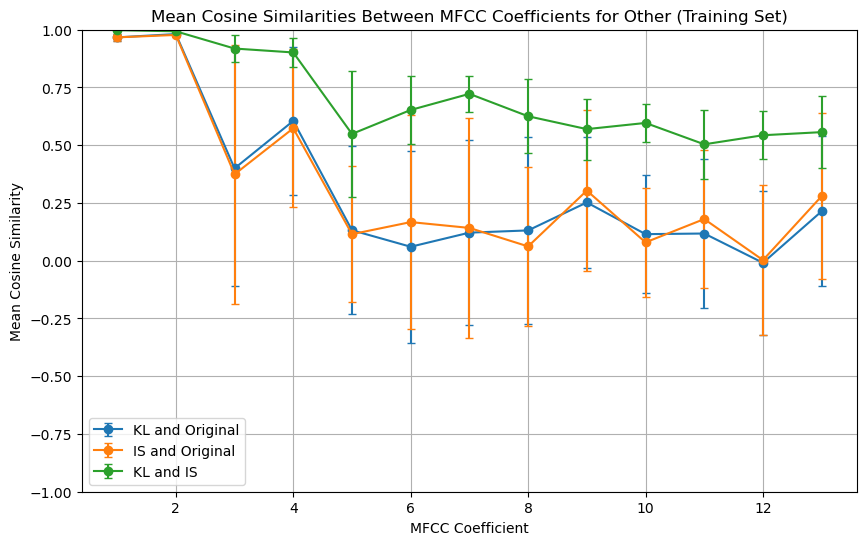

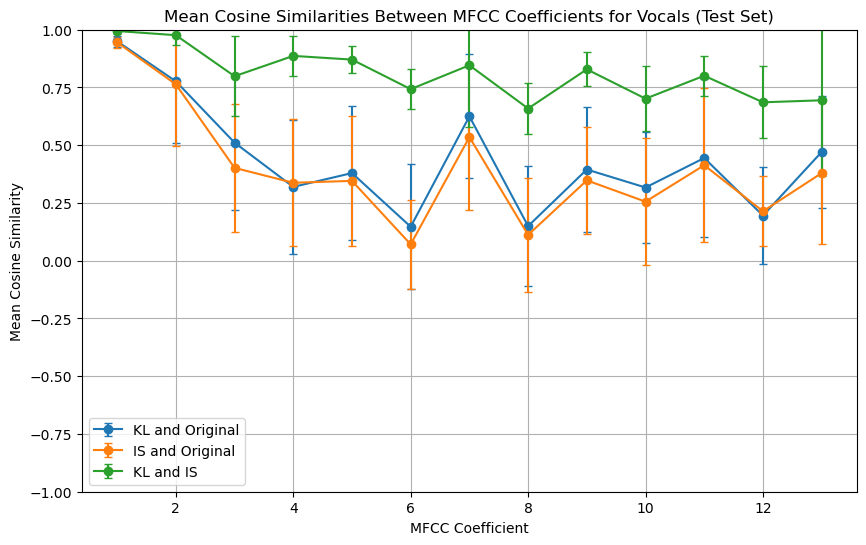

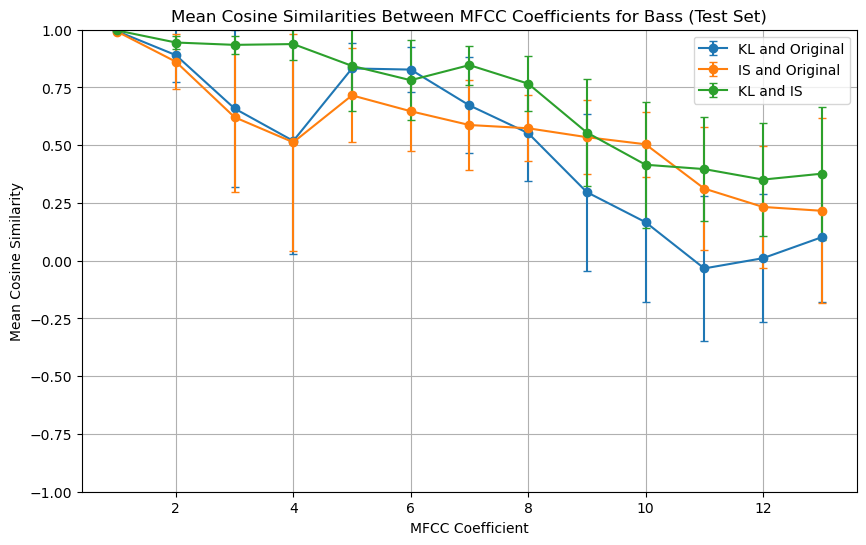

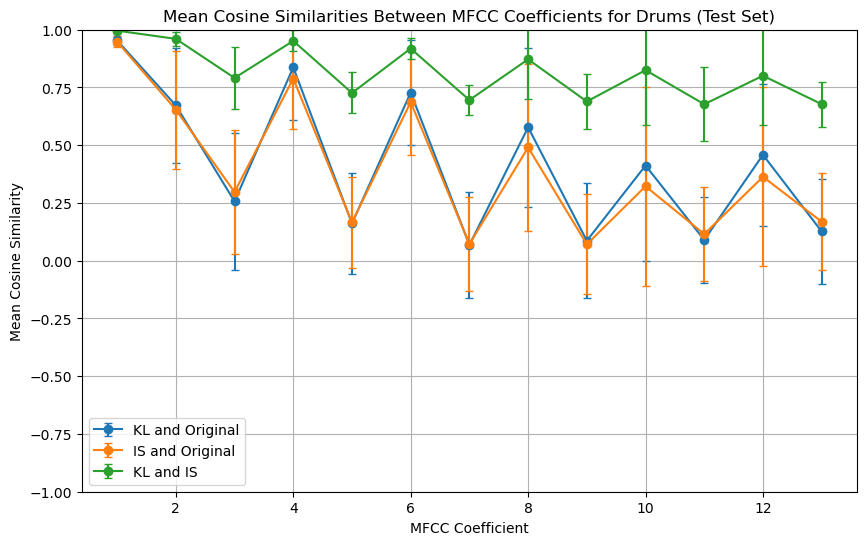

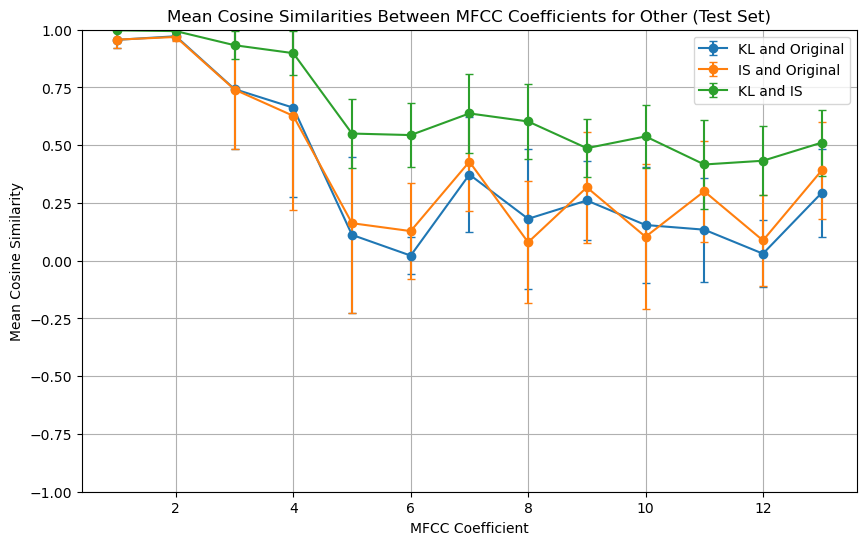

In [20]:
def compute_cosine_similarities_matrices(mfcc_data_orig, mfcc_data_recon, instrument):
    """
    Compute cosine similarities between corresponding MFCC matrices across songs.

    Returns:
        List of arrays containing cosine similarities per MFCC coefficient for each song.
    """
    similarities = []
    num_songs = min(len(mfcc_data_orig[instrument]), len(mfcc_data_recon[instrument]))
    for i in range(num_songs):
        mfcc_orig = mfcc_data_orig[instrument][i]
        mfcc_recon = mfcc_data_recon[instrument][i]

        # Ensure the shapes match
        min_frames = min(mfcc_orig.shape[1], mfcc_recon.shape[1])
        mfcc_orig = mfcc_orig[:, :min_frames]
        mfcc_recon = mfcc_recon[:, :min_frames]

        # Compute cosine similarities
        sim = cosine_similarity_matrices(mfcc_recon, mfcc_orig)

        similarities.append(sim)
    return similarities

cosine_sims_kl_orig_train = {}
for instrument in instruments:
    if instrument in mfcc_data_train and instrument in mfcc_data_nmf_kl_train:
        sims = compute_cosine_similarities_matrices(
            mfcc_data_train, mfcc_data_nmf_kl_train, instrument)
        cosine_sims_kl_orig_train[instrument] = sims

cosine_sims_is_orig_train = {}
for instrument in instruments:
    if instrument in mfcc_data_train and instrument in mfcc_data_nmf_is_train:
        sims = compute_cosine_similarities_matrices(
            mfcc_data_train, mfcc_data_nmf_is_train, instrument)
        cosine_sims_is_orig_train[instrument] = sims

cosine_sims_kl_is_train = {}
for instrument in instruments:
    if instrument in mfcc_data_nmf_kl_train and instrument in mfcc_data_nmf_is_train:
        sims = compute_cosine_similarities_matrices(
            mfcc_data_nmf_kl_train, mfcc_data_nmf_is_train, instrument)
        cosine_sims_kl_is_train[instrument] = sims

cosine_sims_kl_orig_test = {}
for instrument in instruments:
    if instrument in mfcc_data_test and instrument in mfcc_data_nmf_kl_test:
        sims = compute_cosine_similarities_matrices(
            mfcc_data_test, mfcc_data_nmf_kl_test, instrument)
        cosine_sims_kl_orig_test[instrument] = sims

cosine_sims_is_orig_test = {}
for instrument in instruments:
    if instrument in mfcc_data_test and instrument in mfcc_data_nmf_is_test:
        sims = compute_cosine_similarities_matrices(
            mfcc_data_test, mfcc_data_nmf_is_test, instrument)
        cosine_sims_is_orig_test[instrument] = sims

cosine_sims_kl_is_test = {}
for instrument in instruments:
    if instrument in mfcc_data_nmf_kl_test and instrument in mfcc_data_nmf_is_test:
        sims = compute_cosine_similarities_matrices(
            mfcc_data_nmf_kl_test, mfcc_data_nmf_is_test, instrument)
        cosine_sims_kl_is_test[instrument] = sims

def compute_mean_std_cosine_sims(cosine_sims_dict):
    """
    Compute mean and standard deviation of cosine similarities per MFCC coefficient across songs.

    Returns:
        mean_sims: Dictionary with instruments as keys and arrays of mean cosine similarities.
        std_sims: Dictionary with instruments as keys and arrays of std deviations.
    """
    mean_sims = {}
    std_sims = {}
    for instrument, sims_list in cosine_sims_dict.items():
        # Stack the cosine similarity arrays
        sims_array = np.stack(sims_list, axis=0)  # Shape: (num_songs, n_mfcc)
        mean_sims[instrument] = np.mean(sims_array, axis=0)
        std_sims[instrument] = np.std(sims_array, axis=0)
    return mean_sims, std_sims

# Original vs KL
mean_kl_orig_train, std_kl_orig_train = compute_mean_std_cosine_sims(cosine_sims_kl_orig_train)

# Original vs IS
mean_is_orig_train, std_is_orig_train = compute_mean_std_cosine_sims(cosine_sims_is_orig_train)

# KL vs IS
mean_kl_is_train, std_kl_is_train = compute_mean_std_cosine_sims(cosine_sims_kl_is_train)

# Original vs KL
mean_kl_orig_test, std_kl_orig_test = compute_mean_std_cosine_sims(cosine_sims_kl_orig_test)

# Original vs IS
mean_is_orig_test, std_is_orig_test = compute_mean_std_cosine_sims(cosine_sims_is_orig_test)

# KL vs IS
mean_kl_is_test, std_kl_is_test = compute_mean_std_cosine_sims(cosine_sims_kl_is_test)

def plot_mean_cosine_similarities(mean_sims_list, std_sims_list, labels, instrument, title):
    """
    Plot mean cosine similarities with error bars for given data.
    """
    plt.figure(figsize=(10, 6))
    for mean_sims, std_sims, label in zip(mean_sims_list, std_sims_list, labels):
        if instrument not in mean_sims:
            continue
        mean = mean_sims[instrument]
        std = std_sims[instrument]
        plt.errorbar(coefficients, mean, yerr=std, label=label, capsize=3, marker='o')

    plt.xlabel("MFCC Coefficient")
    plt.ylabel("Mean Cosine Similarity")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(-1, 1)
    plt.show()

mean_sims_list_train = [mean_kl_orig_train, mean_is_orig_train, mean_kl_is_train]
std_sims_list_train = [std_kl_orig_train, std_is_orig_train, std_kl_is_train]
labels = ["KL and Original", "IS and Original", "KL and IS"]

for instrument in instruments:
    title = f"Mean Cosine Similarities Between MFCC Coefficients for {instrument.capitalize()} (Training Set)"
    plot_mean_cosine_similarities(mean_sims_list_train, std_sims_list_train, labels, instrument, title)

mean_sims_list_test = [mean_kl_orig_test, mean_is_orig_test, mean_kl_is_test]
std_sims_list_test = [std_kl_orig_test, std_is_orig_test, std_kl_is_test]

for instrument in instruments:
    title = f"Mean Cosine Similarities Between MFCC Coefficients for {instrument.capitalize()} (Test Set)"
    plot_mean_cosine_similarities(mean_sims_list_test, std_sims_list_test, labels, instrument, title)

### Spectrograms

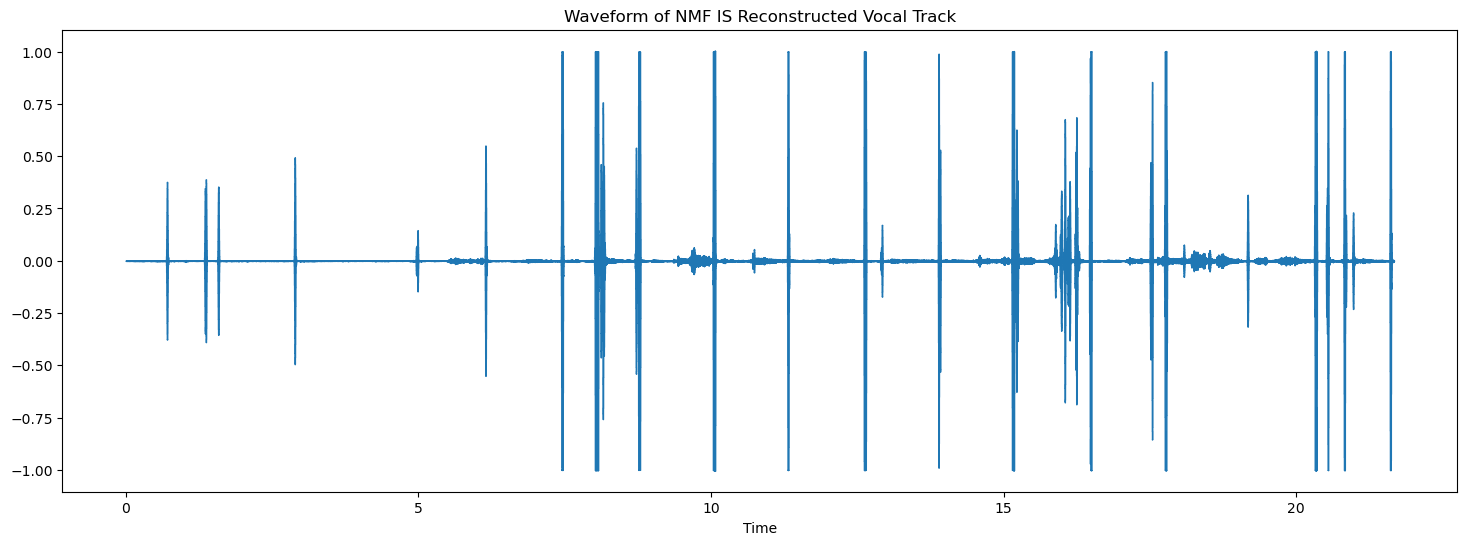

In [66]:
# Load the NMF IS reconstructed vocal track
nmf_is_vocal_path = './track_is/vocals.mp3'
sr = 44100
nmf_is_audio, _ = librosa.load(nmf_is_vocal_path, sr=sr, mono=True)

# Plot waveform of just the NMF IS reconstructed vocal track
plt.figure(figsize=(18, 6))
librosa.display.waveshow(nmf_is_audio, sr=sr)
plt.title('Waveform of NMF IS Reconstructed Vocal Track')
plt.show()